In [1]:
import numpy as np
datall = np.load('./TexasData/datall_Texas.npy')
polall = np.load('./TexasData/polall_Texas.npy')

In [2]:
# !pip install numpy
# !pip install h5py
# !pip install scipy
# !pip install tensorflow

In [3]:
# import tensorflow.compat.v1 as tf1
# tf1.disable_v2_behavior()

In [4]:
import numpy as np
import h5py
import glob
import math
import os
import shutil
from scipy import signal
from scipy.signal import butter, lfilter
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv1D, MaxPooling1D, UpSampling1D, Flatten, Dropout, Reshape 
from tensorflow.keras.layers import Bidirectional, concatenate, BatchNormalization, ZeroPadding1D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.initializers import VarianceScaling
from tensorflow.keras.callbacks import CSVLogger
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
from tensorflow.python.keras.layers import Layer, InputSpec
# import tensorflow as tf
# tf.compat.v1.reset_default_graph()
from sklearn.metrics import accuracy_score

from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.layers import Activation, Add, Bidirectional, Conv1D, Dense, Dropout, Embedding, Flatten, Reshape, multiply
from keras.layers import concatenate, GRU, Input, LSTM, MaxPooling1D
from keras.layers import GlobalAveragePooling1D,  GlobalMaxPooling1D, SpatialDropout1D
from keras.models import Model
# from keras.preprocessing import text, sequence
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
from sklearn.model_selection import train_test_split
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras import backend as K
from keras.models import Model



2024-08-06 12:05:55.936629: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        #x = layers.Dense(units, activation='relu')(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [6]:
drop_rate = 0.2
stochastic_depth_rate = 0.1

w1 = 100

positional_emb = False
conv_layers = 2
num_classes = 1
input_shape = (600,1)
image_size = 600  # We'll resize input images to this size
projection_dim = int(2*w1)
num_heads = 4
transformer_units = [
    projection_dim,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 4

In [7]:
import tensorflow as tf
class CCTTokenizer1(layers.Layer):
    def __init__(
        self,
        kernel_size=4,
        stride=1,
        padding=1,
        pooling_kernel_size=3,
        pooling_stride=(2,2,2,2,2,2,2,2),
        num_conv_layers=conv_layers,
        num_output_channels=[int(projection_dim), int(projection_dim), int(projection_dim), int(projection_dim), int(projection_dim), int(projection_dim), int(projection_dim), int(projection_dim)],
        positional_emb=positional_emb,
        **kwargs,
    ):
        super(CCTTokenizer1, self).__init__(**kwargs)

        # This is our tokenizer.
        self.conv_model = tf.keras.Sequential()
        for i in range(num_conv_layers):
            self.conv_model.add(
                layers.Conv1D(
                    num_output_channels[i],
                    kernel_size,
                    stride,
                    padding="same",
                    use_bias=False,
                    activation="relu",
                    kernel_initializer="he_normal",
                )
            )
            #self.conv_model.add(layers.ZeroPadding2D(padding))
            self.conv_model.add(
                layers.MaxPool1D(pooling_kernel_size, (pooling_stride[i]), "same")
            )

        self.positional_emb = positional_emb

    def call(self, images):
        outputs = self.conv_model(images)
        # After passing the images through our mini-network the spatial dimensions
        # are flattened to form sequences.
        reshaped = tf.reshape(
            outputs,
            (-1, tf.shape(outputs)[1], tf.shape(outputs)[-1]),
        )
        return reshaped

    def positional_embedding(self, image_size):
        # Positional embeddings are optional in CCT. Here, we calculate
        # the number of sequences and initialize an `Embedding` layer to
        # compute the positional embeddings later.
        if self.positional_emb:
            dummy_inputs = tf.ones((1, image_size, 1))
            dummy_outputs = self.call(dummy_inputs)
            sequence_length = dummy_outputs.shape[1]
            projection_dim = dummy_outputs.shape[-1]

            print(dummy_outputs,sequence_length,projection_dim)
            embed_layer = layers.Embedding(
                input_dim=sequence_length, output_dim=projection_dim
            )
            return embed_layer, sequence_length
        else:
            return None

In [8]:
# Referred from: github.com:rwightman/pytorch-image-models.
class StochasticDepth(layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super(StochasticDepth, self).__init__(**kwargs)
        self.drop_prob = drop_prop

    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (tf.shape(x)[0],) + (1,) * (len(tf.shape(x)) - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

In [9]:
#def create_vit_classifier(inputs):
def create_cct_model1(inputs):


    # Augment data.
    #augmented = data_augmentation(inputs)

    # Encode patches.
    cct_tokenizer = CCTTokenizer1()
    encoded_patches = cct_tokenizer(inputs)

    # Apply positional embedding.
    if positional_emb:
        pos_embed, seq_length = cct_tokenizer.positional_embedding(image_size)
        positions = tf.range(start=0, limit=seq_length, delta=1)
        position_embeddings = pos_embed(positions)
        encoded_patches += position_embeddings

    # Calculate Stochastic Depth probabilities.
    dpr = [x for x in np.linspace(0, stochastic_depth_rate, transformer_layers)]

    # Create multiple layers of the Transformer block.
    for i in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.2
        )(x1, x1)

        #print(encoded_patches)
        # Skip connection 1.
        attention_output = StochasticDepth(dpr[i])(attention_output)
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-5)(x2)
        #x3 = x2
        
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.2)

        # Skip connection 2.
        #print(x3)
        x3 = StochasticDepth(dpr[i])(x3)
        #print(x3)
        encoded_patches = layers.Add()([x3, x2])
     
    # Apply sequence pooling.
    representation = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
    
    ''' 
    attention_weights = tf.nn.softmax(layers.Dense(1)(representation), axis=1)
    weighted_representation = tf.matmul(
        attention_weights, representation, transpose_a=True
    )
    weighted_representation = tf.squeeze(weighted_representation, -2)
    '''
    return representation

In [10]:
inputs = layers.Input(shape=input_shape,name='input')

featuresP = create_cct_model1(inputs)
#featuresP = layers.Dropout(0.2)(featuresP)
featuresP = layers.Flatten()(featuresP)
logitp = layers.Dense(1, activation='sigmoid')(featuresP)


#logitp  = Conv2D(1,  3, strides =(1), padding='same',activation='sigmoid', kernel_initializer='he_normal',name='picker_P')(featuresP)


model = Model(inputs=[inputs], outputs=[logitp])
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 600, 1)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cct_tokenizer1      │ (None, 150, 200)  │    160,800 │ input[0][0]       │
│ (CCTTokenizer1)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 150, 200)  │        400 │ cct_tokenizer1[0… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 150, 200)  │    642,600 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stochastic_depth    │ (None, 150, 200)  │          0 │ multi_head_atten… │
│ (StochasticDepth)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 150, 200)  │          0 │ stochastic_depth… │
│                     │                   │            │ cct_tokenizer1[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 150, 200)  │        400 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 150, 200)  │     40,200 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 150, 200)  │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 150, 200)  │     40,200 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 150, 200)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stochastic_depth_1  │ (None, 150, 200)  │          0 │ dropout_2[0][0]   │
│ (StochasticDepth)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 150, 200)  │          0 │ stochastic_depth… │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 150, 200)  │        400 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 150, 200)  │    642,600 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stochastic_depth_2  │ (None, 150, 200)  │          0 │ multi_head_atten… │
│ (StochasticDepth)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 150, 200)  │          0 │ stochastic_depth… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 150, 200)  │        400 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 3,086,401 (11.77 MB)

 Trainable params: 3,086,401 (11.77 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
inputs = layers.Input(shape=input_shape,name='input')

featuresP = create_cct_model1(inputs)
featuresP = layers.Flatten()(featuresP)
featuresP = layers.Dropout(0.2)(featuresP)
logitp = layers.Dense(1, activation='sigmoid')(featuresP)


#logitp  = Conv2D(1,  3, strides =(1), padding='same',activation='sigmoid', kernel_initializer='he_normal',name='picker_P')(featuresP)


model = Model(inputs=[inputs], outputs=[logitp])
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 600, 1)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cct_tokenizer1_1    │ (None, 150, 200)  │    160,800 │ input[0][0]       │
│ (CCTTokenizer1)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 150, 200)  │        400 │ cct_tokenizer1_1… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 150, 200)  │    642,600 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stochastic_depth_8  │ (None, 150, 200)  │          0 │ multi_head_atten… │
│ (StochasticDepth)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 150, 200)  │          0 │ stochastic_depth… │
│                     │                   │            │ cct_tokenizer1_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 150, 200)  │        400 │ add_8[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 150, 200)  │     40,200 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 150, 200)  │          0 │ dense_9[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 150, 200)  │     40,200 │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 150, 200)  │          0 │ dense_10[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stochastic_depth_9  │ (None, 150, 200)  │          0 │ dropout_14[0][0]  │
│ (StochasticDepth)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 150, 200)  │          0 │ stochastic_depth… │
│                     │                   │            │ add_8[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 150, 200)  │        400 │ add_9[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 150, 200)  │    642,600 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stochastic_depth_10 │ (None, 150, 200)  │          0 │ multi_head_atten… │
│ (StochasticDepth)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 150, 200)  │          0 │ stochastic_depth… │
│                     │                   │            │ add_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 150, 200)  │        400 │ add_10[0][0]    

 Total params: 3,086,401 (11.77 MB)

 Trainable params: 3,086,401 (11.77 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.load_weights('best_weigths_Binary_CSCN_Best.h5')


In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np


out = model.predict(datall,batch_size=1024, verbose=1)

23/23 ━━━━━━━━━━━━━━━━━━━━ 419s 18s/step


In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#outtest = np.argmax(out,axis=-1)
thre = 0.5
outtest = out
outtest[outtest<thre]=0
outtest[outtest>=thre]=1
labtest = polall

accuracy_score(labtest,outtest),precision_score(labtest,outtest, average='micro'),recall_score(labtest,outtest, average='micro'),f1_score(labtest,outtest, average='micro')

(0.9459094865100087,
 0.9459094865100087,
 0.9459094865100087,
 0.9459094865100087)

In [15]:
accuracy_score(labtest,outtest),precision_score(labtest,outtest, average=None),recall_score(labtest,outtest, average=None),f1_score(labtest,outtest, average=None)

(0.9459094865100087,
 array([0.97869277, 0.89579665]),
 array([0.93488276, 0.96491644]),
 array([0.95628627, 0.92907275]))

In [16]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(labtest, outtest)

print(cf_matrix)

[[13596   947]
 [  296  8141]]


<Axes: >

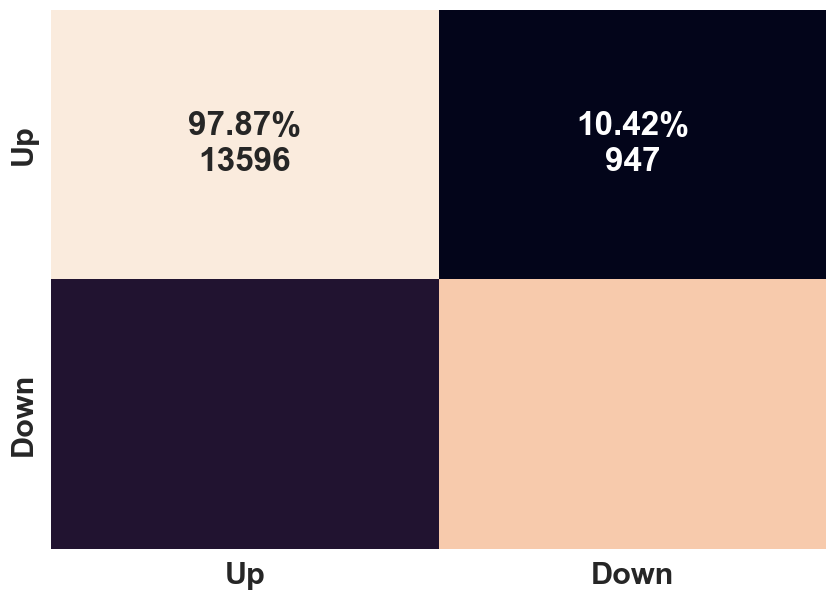

In [17]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}
plt.rc('font', **font)

cf = cf_matrix
categories=['Up','Down']
group_percentages = []
counts = []
for i in range(len(cf)):
    for j in range(len(cf)):
        group_percentages.append(cf[j, i]/np.sum(cf[:, i]))
        counts.append(cf[j, i])

percentages_matrix = np.reshape(group_percentages, (2, 2))
group_percentages = ['{0:.2%}'.format(value) for value in group_percentages]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_percentages, counts)]
labels = np.asarray(labels).reshape(2, 2, order = 'F')

fig = plt.figure(figsize=(10,7))
sn.set(font_scale=2) # for label size
sn.heatmap(percentages_matrix, annot = labels, fmt = '', xticklabels=categories, yticklabels = categories, cbar = False)
#fig.savefig('Conf_Matrix',bbox_inches='tight',transparent=True, dpi =100)


In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


checkpoint = ModelCheckpoint(filepath='best_weigths_Binary_Texas_Transfer10.weights.h5',
                             monitor='val_acc',
                             mode = 'max',
                             verbose=1,
                             save_weights_only=True,
                             save_best_only=True)

lr_reducer = ReduceLROnPlateau(factor=0.1,
                                   cooldown=0,
                                   patience=50,
                                   min_lr=0.5e-6,
                                   monitor='val_acc',
                                   mode = 'max',
                                  verbose= 1)

In [19]:
import numpy as np
ind = np.random.permutation(len(datall))
a = int(10*len(ind)/100)
ind = ind[0:a]
x = datall[ind]
y = polall[ind]

model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=['binary_crossentropy'], metrics=['acc'])
model.load_weights('best_weigths_Binary_CSCN_Best.h5')

model.fit(x, y, batch_size=128, epochs=50, verbose =1, validation_split=0.1, shuffle=True, callbacks=[checkpoint,lr_reducer])

Epoch 1/50


TypeError: Exception encountered when calling StochasticDepth.call().

[1mlen is not well defined for a symbolic Tensor (functional_5_1/stochastic_depth_8_1/Shape_1:0). Please call `x.shape` rather than `len(x)` for shape information.[0m

Arguments received by StochasticDepth.call():
  • x=tf.Tensor(shape=(None, 150, 200), dtype=float32)
  • training=True

In [ ]:
model.load_weights('best_weigths_Binary_Texas_Transfer10.h5')
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np


out = model.predict(datall,batch_size=1024, verbose=1)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#outtest = np.argmax(out,axis=-1)
thre = 0.5
outtest = out
outtest[outtest<thre]=0
outtest[outtest>=thre]=1
labtest = polall

accuracy_score(labtest,outtest),precision_score(labtest,outtest, average='micro'),recall_score(labtest,outtest, average='micro'),f1_score(labtest,outtest, average='micro')

In [ ]:
accuracy_score(labtest,outtest),precision_score(labtest,outtest, average=None),recall_score(labtest,outtest, average=None),f1_score(labtest,outtest, average=None)

In [ ]:
accuracy_score(labtest,outtest),precision_score(labtest,outtest, average='macro'),recall_score(labtest,outtest, average='macro'),f1_score(labtest,outtest, average='macro')